In [1]:
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/path name/"
except ModuleNotFoundError:
    core_path = ""

# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus_Class"].to_list())

Mounted at /gdrive


In [3]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [4]:
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [5]:
import keras
from keras.layers import Input, Conv1D, Conv1DTranspose, Flatten, Dense, Reshape
from keras.models import Model
from keras.optimizers import Adam

n_inputs = asteroids_X.shape[1]
n_bottleneck = 5

def create_model():
    # Input layer, this time without a normalization layer
    input_layer = Input(shape=(n_inputs, 1))

    # Convolutional Layers
    x = Conv1D(filters=16, kernel_size=3, activation="relu", padding="same")(input_layer)
    x = Conv1D(filters=32, kernel_size=3, activation="relu", padding="same")(x)

    # Encoder ("Bottleneck" of the Autoencoder)
    bottleneck_lay = Flatten()(x)
    bottleneck_lay = Dense(n_bottleneck)(bottleneck_lay)

    # The original shape must be restored and reshaped accordingly
    reset_lay = Dense(49 * 32)(bottleneck_lay)
    reshape_lay = Reshape((49, 32))(reset_lay)

    # First and second hidden decoder layers
    x = Conv1DTranspose(filters=32, kernel_size=3, strides=1, activation="relu", padding="same")(reshape_lay)
    x = Conv1DTranspose(filters=16, kernel_size=3, strides=1, activation="relu", padding="same")(x)

    # Output layer (same size as input layer)
    output_layer = Conv1D(1, 1, padding="same")(x)

    # Create the autoencoder model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Create the encoder model
    encoder_model = Model(inputs=input_layer, outputs=bottleneck_lay)

    return model, encoder_model

model, encoder_model = create_model()

# Compile the model and use a mean squared error (MSE) loss function
model.compile(optimizer='adam', loss='mse')

# Show the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 49, 16)            64        
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 32)            1568      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 5)                 7845      
                                                                 
 dense_1 (Dense)             (None, 1568)              9408      
                                                                 
 reshape (Reshape)           (None, 49, 32)            0     

In [6]:
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    callbacks=[es_callback])

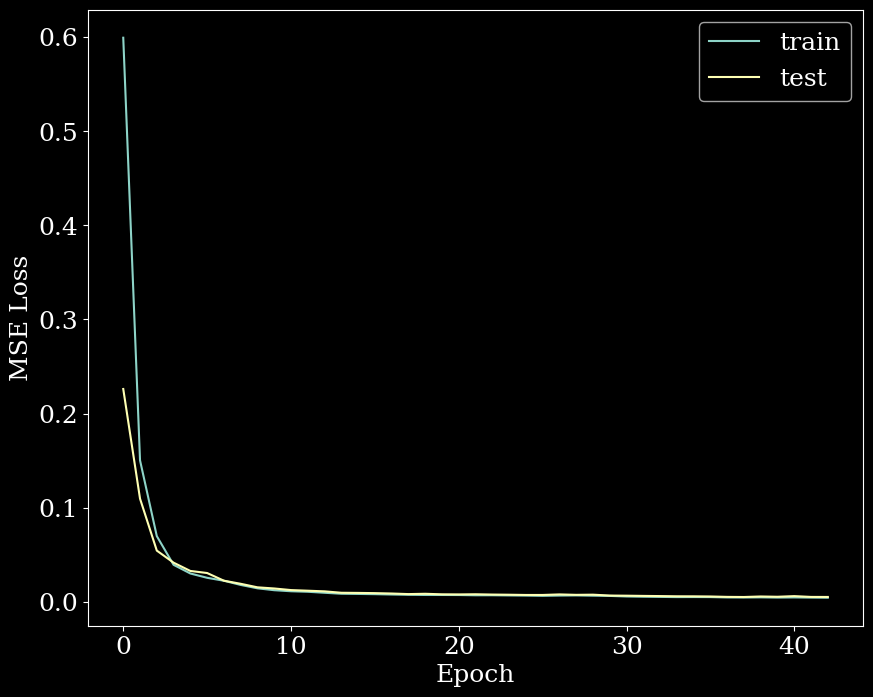

In [7]:
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

plt.show()

34/34 [==============================] - 0s 2ms/step


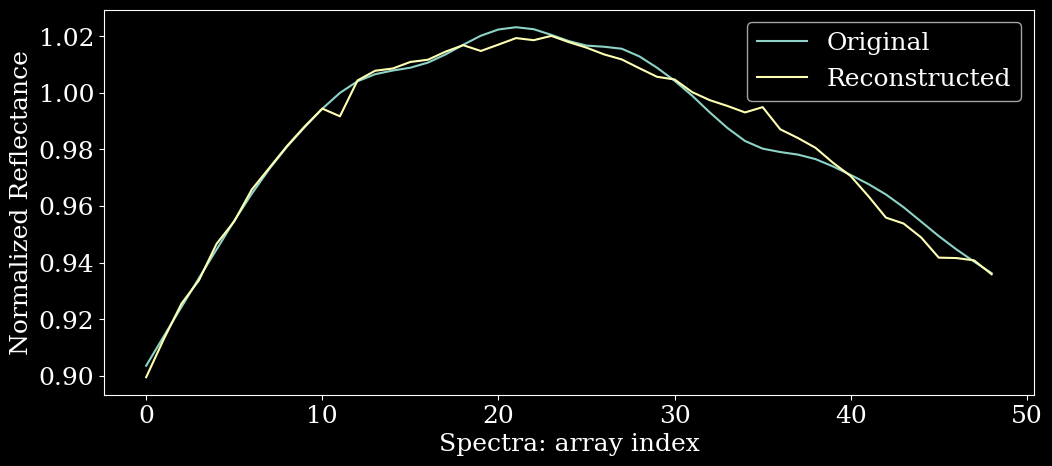

In [8]:
index_val = 5

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")


plt.show()

In [9]:
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the encoded data to fit
# the scaler
enc_scaler = preprocessing.StandardScaler().fit(X_encoded)

# Transform now the encoded data (later used for our scikit-learn method)
X_encoded_scaled = enc_scaler.transform(X_encoded)

# Merge the classes
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create a column names array for the encoded space
encoder_space = [f"enc{enc_nr+1}" for enc_nr in range(n_bottleneck)]
encoder_space_cols = encoder_space.copy()
encoder_space.extend(["Main_Group", "Bus_Class"])

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded_scaled,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=encoder_space)

# Change the dtype to float
encoded_df.loc[:, encoder_space[:-2]] = encoded_df.loc[:, encoder_space[:-2]].astype(float)

9/9 [==============================] - 0s 4ms/step


In [10]:
import sklearn.mixture
import tqdm
import pandas as pd

# Create a list to store results as dictionaries
results = []

# Iterate through a range of component guesses
max_gauss = 15
for gauss_components in tqdm.tqdm(range(1, max_gauss+1)):

    # Create and fit a temporary Gaussian Mixture Model
    temp_gmm = sklearn.mixture.GaussianMixture(n_components=gauss_components,
                                               covariance_type="full")
    temp_gmm.fit(X_encoded_scaled)

    # Store the results as a dictionary
    result = {
        "Nr_Comp": gauss_components,
        "BIC": temp_gmm.bic(X_encoded_scaled),
        "Model": temp_gmm
    }

    results.append(result)

# Create the results DataFrame
gmm_results_df = pd.DataFrame(results)


100%|██████████| 15/15 [00:02<00:00,  5.88it/s]


(1.0, 15.0)

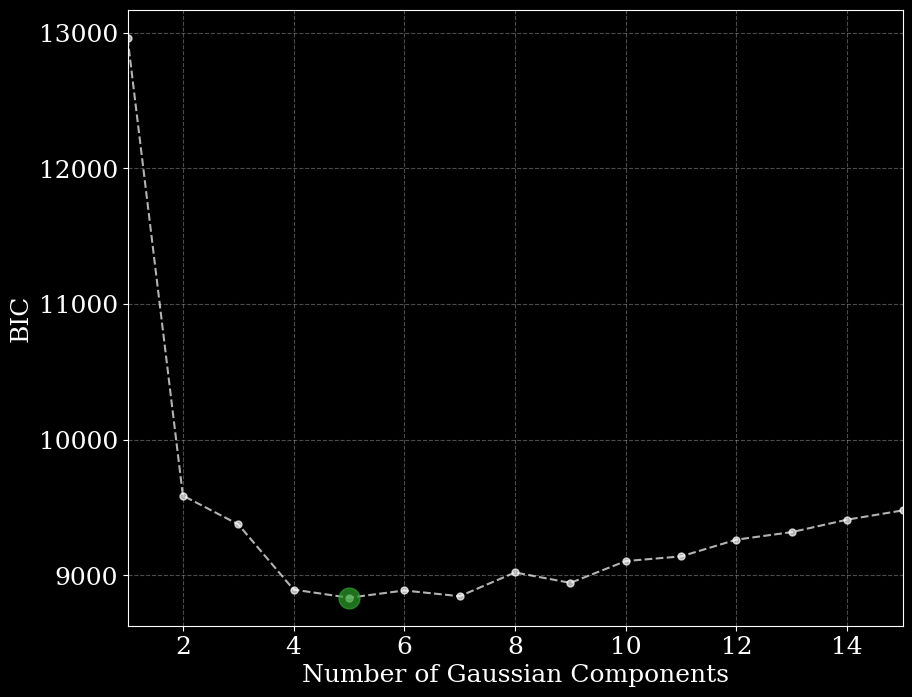

In [11]:
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Plotting the BIC vs. the number of components
plt.figure(figsize=(10, 8))

plt.plot(gmm_results_df["Nr_Comp"],
         gmm_results_df["BIC"],
         linestyle="dashed",
         marker="o",
         markersize=5,
         color="w",
         alpha=0.7)

# Color the minimum value
gmm_results_best = gmm_results_df.loc[gmm_results_df["BIC"] == gmm_results_df["BIC"].min()]
plt.plot(gmm_results_best["Nr_Comp"],
         gmm_results_best["BIC"],
         marker="o",
         markersize=15,
         color="tab:green",
         alpha=0.7)

# Some formatting
plt.xlabel("Number of Gaussian Components")
plt.ylabel("BIC")
plt.grid(linestyle="dashed", alpha=0.3)
plt.xlim(1, max_gauss)

In [12]:
best_gmm = gmm_results_best["Model"].iloc[0]

# Create a new dataframe column that labels the spectra based on our GMM model:
encoded_df.loc[:, "GMM_Class"] = best_gmm.predict(encoded_df[encoder_space_cols].values)

encoded_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class
0,-1.41196,1.466268,0.014436,0.388601,1.600125,C,B,0
1,-1.322928,0.466023,-0.759433,-0.768982,0.018354,C,Cgh,0
2,0.290767,-0.089496,-0.394749,-1.193821,0.328606,S,Sk,2
3,-1.53265,1.579383,0.639766,-0.692412,1.172651,C,B,1
4,0.995895,0.82793,1.491776,-1.773916,0.602584,Other,V,4
...,...,...,...,...,...,...,...,...
1326,0.005722,-0.435473,-1.135759,-0.708748,0.668122,X,Xk,1
1327,0.96704,-0.956902,0.730204,0.721573,-1.089765,S,S,2
1328,0.319139,-0.223584,-0.699425,-1.351471,0.474396,S,Sk,2
1329,-1.980711,2.081161,0.248039,0.111732,1.496578,C,Ch,0


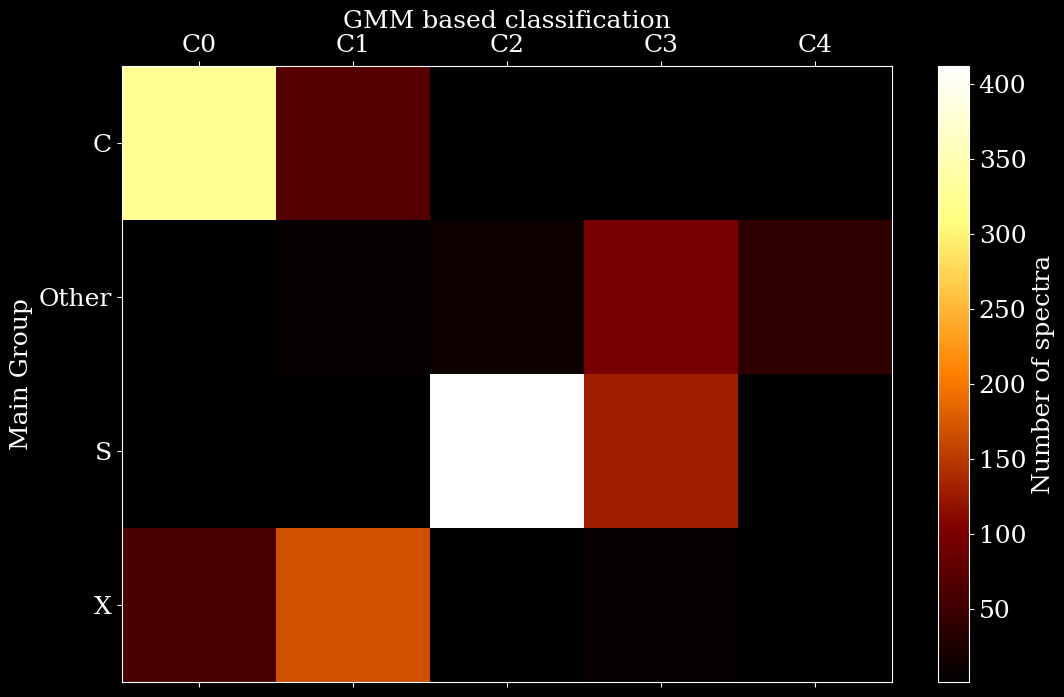

In [13]:
encoded_grouped_df = pd.crosstab(index=encoded_df["Main_Group"],
                                 columns=encoded_df["GMM_Class"],
                                 values=encoded_df["enc1"],
                                 aggfunc="count")

# Extract data, column and index names for plotting purposes
encoded_grouped_values = encoded_grouped_df.values
encoded_grouped_main = encoded_grouped_df.index.values
encoded_grouped_gmm = [f"C{k}" for k in encoded_grouped_df.columns.values]


# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Create a matrix-like plot of the results
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(encoded_grouped_values, cmap="afmhot")
fig.colorbar(cax, label="Number of spectra", fraction=0.05)

# Some plotting settings
ax.set_xticks(range(len(encoded_grouped_gmm)))
ax.set_yticks(range(len(encoded_grouped_main)))
ax.set_xticklabels(encoded_grouped_gmm)
ax.set_yticklabels(encoded_grouped_main)

ax.set_xlabel("GMM based classification")
ax.set_ylabel("Main Group")
ax.xaxis.set_label_position('top')